In [1]:
# Packages laden
import numpy as np
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Input, Dense
from matplotlib import pyplot as plt
from pandas import DataFrame
from keras.datasets import mnist
from keras.utils import np_utils
from keras.layers import Dropout, Activation, Flatten,TimeDistributed, BatchNormalization, LeakyReLU, Activation 
from keras.models import Model
from pandas import concat
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Laden der Daten
DATA_FILE="Dropbox/Masterarbeit/Masterarbeit/Datensätze/Geburtenrate/Datensatz.xlsx"
df = pd.read_excel(DATA_FILE)
df=pd.read_excel(DATA_FILE, header=0, parse_dates=[0], index_col='Jahr-Monat',squeeze=True)

In [3]:
# Ein array mit allen Einträgen --> zur besseren Weiterverarbeitung
ZR=df.values

In [4]:
# Anteil der Datensätze am Gesamtdatensatz
ZR_100=ZR

# Unterteilung der Teildatensätze in Trainings-und Testdaten
ZR_100_TR, ZR_100_TE= ZR_100[0:605], ZR_100[605:len(ZR_100)]

In [5]:
# Funktion: Datensatz erstellen mit Inputs (look_back: Anzahl der verwendten Vergangenheitswerte) + Output (look_forward: 
# Vorhersagehorizont)
def timeseries_to_supervised_R(data, look_back, look_forward):
    df = DataFrame(data)
    columns = [df.shift(look_forward-1+i) for i in range(1, look_back+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    #df = df.drop(0)
    DF=df[::-1]
    df=DF[:len(df)-(look_back+look_forward-1)]
    DF=df[::-1]
    return DF

In [6]:
# Festlegung: look_back, look_forward + Anwendung der Funktion
# Inputneuronen: 12
# Vorhersagehorizont: t+240
look_back=12
look_forward=240

# Inputgröße 100%
# Trainingsdaten
ZR_100_TR_I=timeseries_to_supervised_R(ZR_100_TR, look_back, look_forward)
trainX_100, train_y_100 = ZR_100_TR_I.iloc[:, 0:-1], ZR_100_TR_I.iloc[:, -1]

# Testdaten 
ZR_100_TE_I=timeseries_to_supervised_R(ZR_100_TE, look_back, look_forward)
testX_100, test_y_100 = ZR_100_TE_I.iloc[:, 0:-1], ZR_100_TE_I.iloc[:, -1]

In [31]:
# Replizierbarkeit gewährleisten
np.random.seed(6)

In [32]:
# Modell zusammenbauen
# Dateninput: 100 %
model = Sequential()
model.add(Dense(10, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history_reg=model.fit(trainX_100, train_y_100, epochs=25, verbose=2,validation_data=(testX_100, test_y_100))

Train on 354 samples, validate on 7 samples
Epoch 1/25
 - 1s - loss: 11227932660.4294 - val_loss: 7501869568.0000
Epoch 2/25
 - 0s - loss: 9372451582.5537 - val_loss: 5772633088.0000
Epoch 3/25
 - 0s - loss: 6146932299.2090 - val_loss: 3605801216.0000
Epoch 4/25
 - 0s - loss: 3252993907.7062 - val_loss: 2024192768.0000
Epoch 5/25
 - 0s - loss: 1487914036.9718 - val_loss: 1057865280.0000
Epoch 6/25
 - 0s - loss: 634272518.3277 - val_loss: 544196352.0000
Epoch 7/25
 - 0s - loss: 318287442.1695 - val_loss: 309635616.0000
Epoch 8/25
 - 0s - loss: 252903438.5537 - val_loss: 214346768.0000
Epoch 9/25
 - 0s - loss: 244637458.1052 - val_loss: 199667328.0000
Epoch 10/25
 - 0s - loss: 245778361.2203 - val_loss: 202092768.0000
Epoch 11/25
 - 0s - loss: 245391655.7740 - val_loss: 216311840.0000
Epoch 12/25
 - 0s - loss: 245084943.3672 - val_loss: 212184224.0000
Epoch 13/25
 - 0s - loss: 245299640.9492 - val_loss: 223349808.0000
Epoch 14/25
 - 0s - loss: 245378609.5367 - val_loss: 216168400.0000
Ep

Text(0.5,1,'Loss Curves')

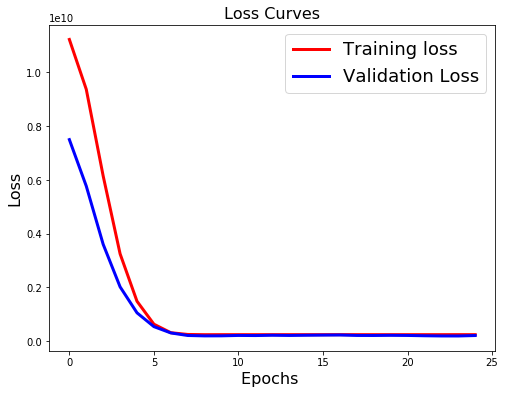

In [33]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [34]:
# Modellperformance bewerten: normalisierte Daten
trainScore = model.evaluate(trainX_100, train_y_100, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX_100, test_y_100, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 244978798.33 MSE (15651.80 RMSE)
Test Score: 213114544.00 MSE (14598.44 RMSE)


In [35]:
# Vorhersagen generieren
trainPredict_100 = model.predict(trainX_100)
testPredict_100 = model.predict(testX_100)

In [36]:
# Evaluation
test_MSE=mean_squared_error(test_y_100,testPredict_100)
train_MSE=mean_squared_error(train_y_100,trainPredict_100)

print(test_MSE,train_MSE)

213114554.3448312 244978789.6504392


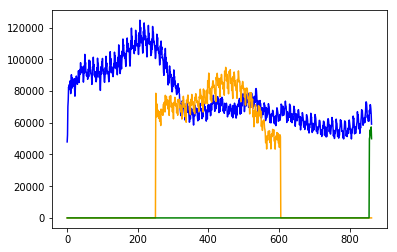

In [37]:
# Verschiebund der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_100)
trainPredictPlot=trainPredictPlot.reshape(len(ZR_100))
trainPredictPlot[:]=[0]*len(ZR_100)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_100),1)
trainPredictPlot[(look_back+look_forward-1):len(trainPredict_100)+(look_back+look_forward-1)] = trainPredict_100

# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_100)
testPredictPlot=testPredictPlot.reshape(len(ZR_100))
testPredictPlot[:]=[0]*len(ZR_100)
testPredictPlot = testPredictPlot.reshape(len(ZR_100),1)
testPredictPlot[len(trainPredict_100)+2*(look_back+look_forward-1):len(ZR_100)+1] = testPredict_100
 
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_100, color='blue')
plt.plot(trainPredictPlot, color='orange')
plt.plot(testPredictPlot, color='green')
plt.show()